# Fourier Radon transform

The aim of this notebook is to show how to use the FourierRadon2D and FourierRadon3D implementations in Pylops.

In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pyfftw
import pylops

from scipy.signal.windows import hann
from numba import jit, prange
from pylops.basicoperators import FunctionOperator
from pylops.signalprocessing import *
from pylops.utils import dottest

from pylops.signalprocessing.fourierradon2d import FourierRadon2D

from visual import explode_volume

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2D

In [23]:
kind = "parabolic" # linear
flims = [0, 22] # None

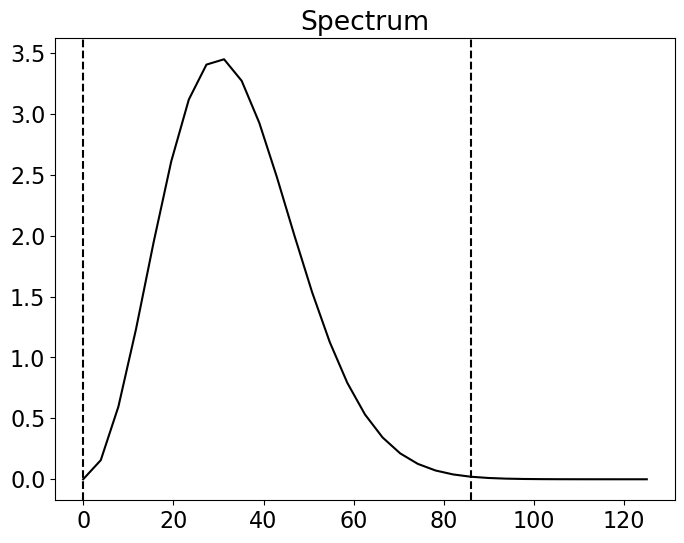

In [24]:
# Create axis (small centered)
par = {'ot': 0,    'dt': 0.004, 'nt': 60,
       'ox': -250, 'dx': 10, 'nx': 51,
       'oy': -250, 'dy': 10, 'ny': 51,
       'f0': 30}
theta = [20, ]
t0 = [0.1, ]
amp = [1., ]

# Create axis (small shifted)
#par = {'ot': 0,    'dt': 0.004, 'nt': 101,
#       'ox': 0, 'dx': 10, 'nx': 51,
#       'oy': -250, 'dy': 10, 'ny': 51,
#       'f0': 40}
#theta = 20
#t0 = 0.1
#amp = 1.

# Create axis (large centered)
#par = {'ot': 0,    'dt': 0.004, 'nt': 501,
#       'ox': -1000, 'dx': 10, 'nx': 201,
#       'oy': -250, 'dy': 10, 'ny': 51,
#       'f0': 40}
#theta = [20, ]
#t0 = [0.8, ]
#amp = [1., ]

# Create axis
t, t2, x, _ = pylops.utils.seismicevents.makeaxis(par)
dt, dx = par['dt'], par['dx']

# Create wavelet
wav, _, wav_c = pylops.utils.wavelets.ricker(t[:41], f0=par['f0'])

# Generate model
if kind == "linear":
    v = 1500.
    pxx = np.sin(np.deg2rad(theta)) / v
    _, d = \
        pylops.utils.seismicevents.linear2d(x, t, v, t0, theta, amp, wav)
    npx, pxmax = 4 * par['nx'], 5e-4
    px = np.linspace(-pxmax, pxmax, npx)
    px_fou = px
else:
    pxx = 5e-7 * par['dx']
    _, d = \
        pylops.utils.seismicevents.parabolic2d(x, t, t0, 0, pxx / par['dx'], amp, wav)
    npx, pxmax = 4 * par['nx'], 2e-6
    px = np.linspace(-pxmax, pxmax, npx) * par['dx']
    px_fou = np.linspace(-pxmax, pxmax, npx)

nfft = int(2 ** np.ceil(np.log2(par['nt'])))
faxis = np.fft.rfftfreq(nfft, par["dt"])

plt.figure()
#plt.plot(np.mean(np.abs(np.fft.rfft(d, n=nfft, axis=-1)), axis=0), 'k')
plt.plot(faxis, np.abs(np.fft.rfft(d[par['nx']//2], n=nfft)), 'k')
if flims is not None:
    plt.axvline(faxis[flims[0]], color='k', linestyle='--')
    plt.axvline(faxis[flims[1]], color='k', linestyle='--')
plt.title('Spectrum');

Standard Radon

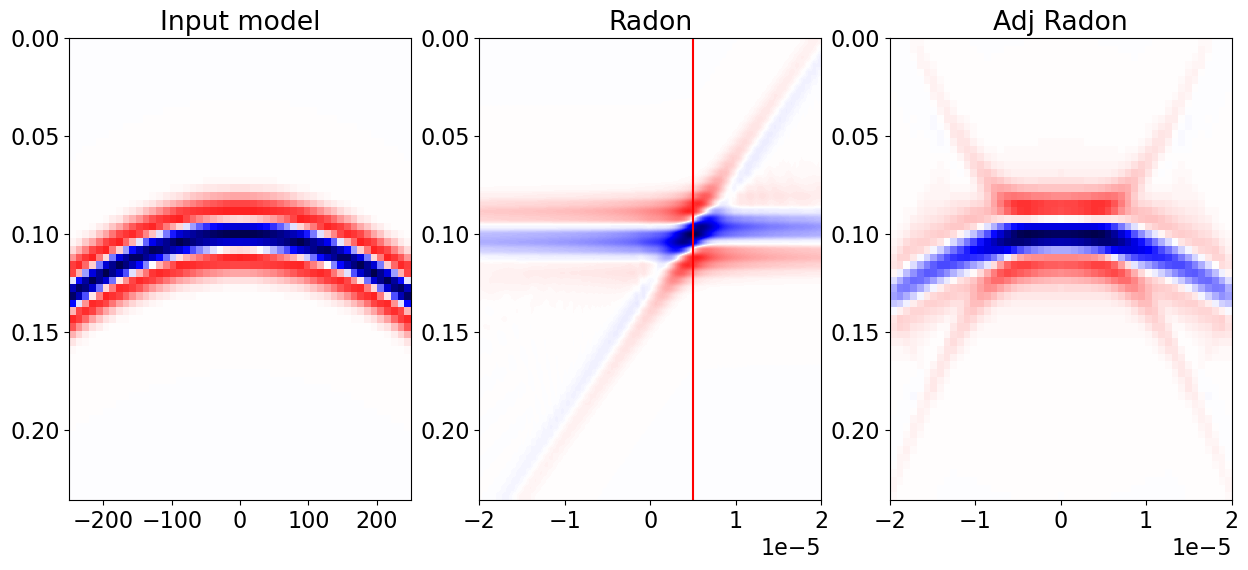

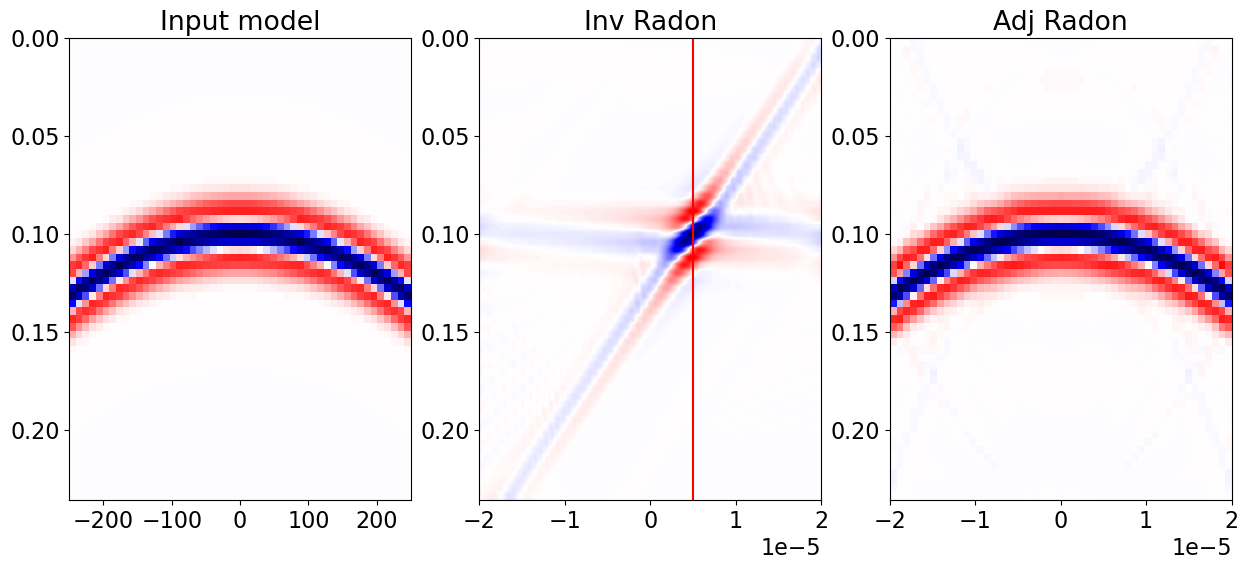

In [25]:
R2Opnormal = Radon2D(t, x, px, centeredh=False, 
                     kind=kind, dtype='float64', 
                     engine='numba')
dL_normal = R2Opnormal.H * d
dadj_normal = R2Opnormal * dL_normal

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d.T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dL_normal.T, cmap='seismic_r', vmin=-dL_normal.max(), vmax=dL_normal.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].axvline(pxx, color='r')
axs[1].set_title('Radon')
axs[1].axis('tight')
axs[2].imshow(dadj_normal.T, cmap='seismic_r', vmin=-dadj_normal.max(), vmax=dadj_normal.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon')
axs[2].axis('tight');

dLinv_normal = R2Opnormal.div(d.ravel(), niter=10).reshape(R2Opnormal.dims)
dinv_normal = R2Opnormal * dLinv_normal

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d.T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dLinv_normal.T, cmap='seismic_r', vmin=-dLinv_normal.max(), vmax=dLinv_normal.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].axvline(pxx, color='r')
axs[1].set_title('Inv Radon')
axs[1].axis('tight')
axs[2].imshow(dinv_normal.T, cmap='seismic_r', vmin=-dinv_normal.max(), vmax=dinv_normal.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon')
axs[2].axis('tight');

Radon in frequency domain (numpy)

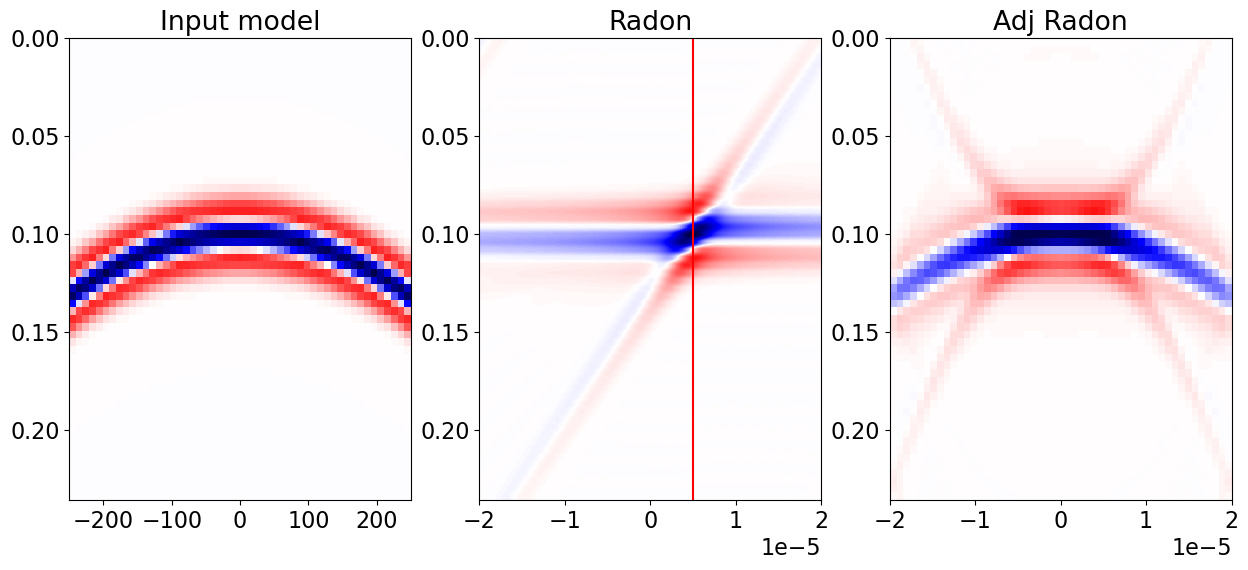

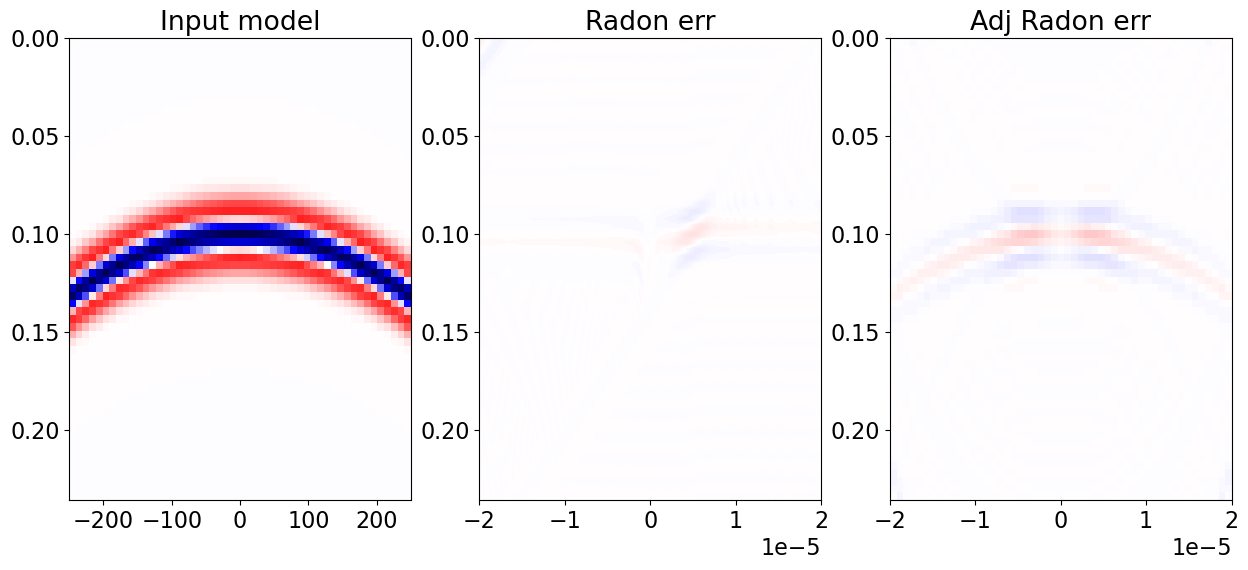

In [26]:
R2Opfourier = FourierRadon2D(t, x, px_fou, nfft, flims=flims, kind=kind, engine='numpy', dtype='float64')
dL_four = R2Opfourier.H * d
dadj_four = R2Opfourier * dL_four

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d.T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dL_four.T, cmap='seismic_r', vmin=-dL_normal.max(), vmax=dL_normal.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].axvline(pxx, color='r')
axs[1].set_title('Radon')
axs[1].axis('tight')
axs[2].imshow(dadj_four.T, cmap='seismic_r', vmin=-dadj_normal.max(), vmax=dadj_normal.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon')
axs[2].axis('tight');

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d.T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dL_normal.T - dL_four.T, cmap='seismic_r', vmin=-dL_normal.max(), vmax=dL_normal.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon err')
axs[1].axis('tight')
axs[2].imshow(dadj_normal.T - dadj_four.T, cmap='seismic_r', vmin=-dadj_normal.max(), vmax=dadj_normal.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon err')
axs[2].axis('tight');

Radon in frequency domain (numba)

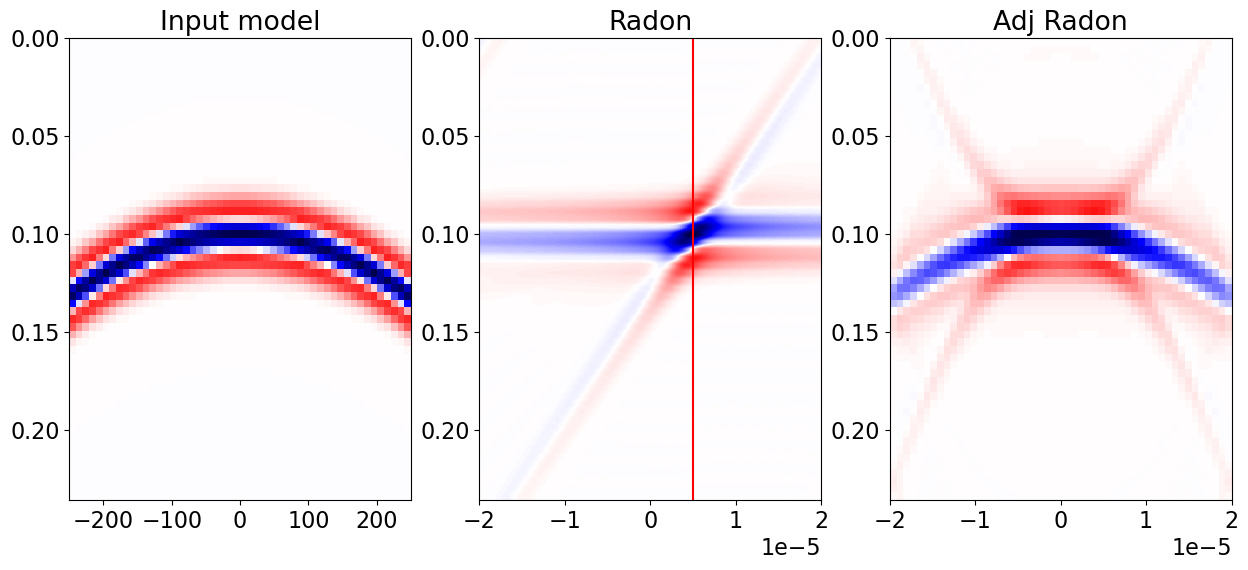

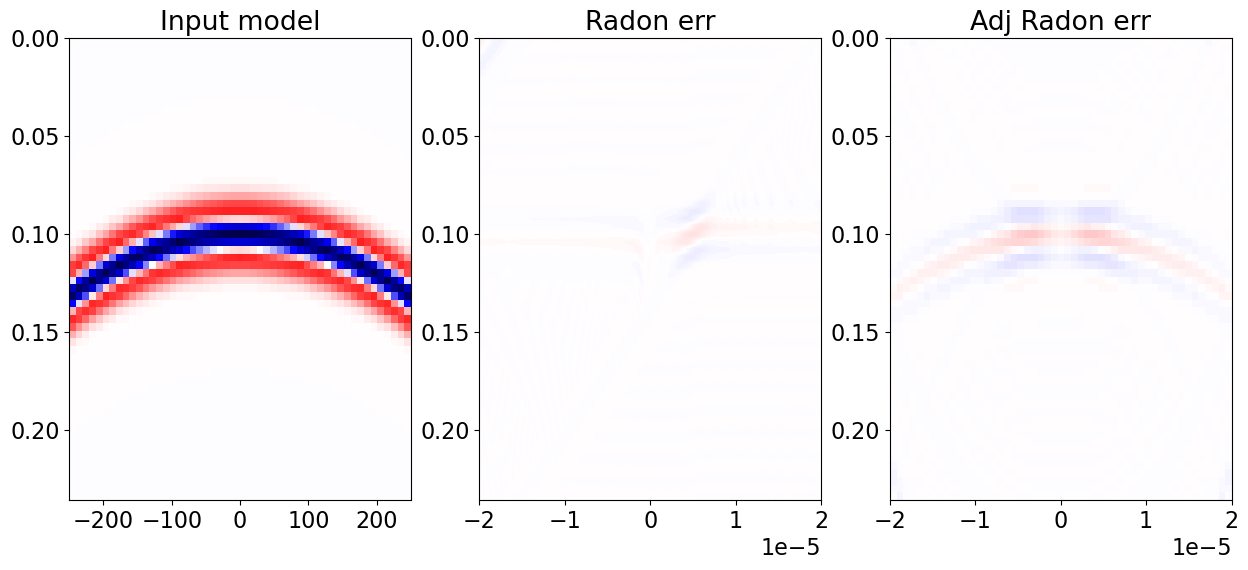

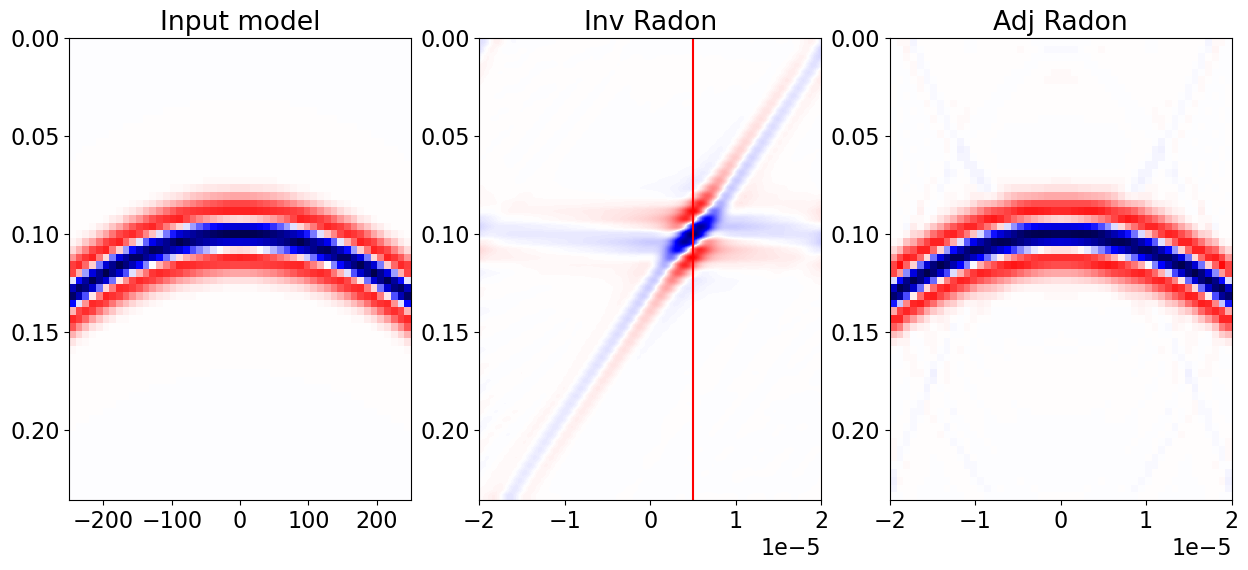

In [27]:
nfft = int(2 ** np.ceil(np.log2(par['nt'])))
R2Opfouriernb = FourierRadon2D(t, x, px_fou, nfft, flims=flims, kind=kind, engine='numba', dtype='float64')
dL_four = R2Opfouriernb.H * d
dadj_four = R2Opfouriernb * dL_four

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d.T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dL_four.T, cmap='seismic_r', vmin=-dL_normal.max(), vmax=dL_normal.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].axvline(pxx, color='r')
axs[1].set_title('Radon')
axs[1].axis('tight')
axs[2].imshow(dadj_four.T, cmap='seismic_r', vmin=-dadj_normal.max(), vmax=dadj_normal.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon')
axs[2].axis('tight');

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d.T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dL_normal.T - dL_four.T, cmap='seismic_r', vmin=-dL_normal.max(), vmax=dL_normal.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon err')
axs[1].axis('tight')
axs[2].imshow(dadj_normal.T - dadj_four.T, cmap='seismic_r', vmin=-dadj_normal.max(), vmax=dadj_normal.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon err')
axs[2].axis('tight');

dLinv_four = R2Opfouriernb.div(d.ravel(), niter=10).reshape(R2Opnormal.dims)
dinv_four = R2Opfouriernb * dLinv_four

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d.T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dLinv_four.T, cmap='seismic_r', vmin=-dLinv_normal.max(), vmax=dLinv_normal.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].axvline(pxx, color='r')
axs[1].set_title('Inv Radon')
axs[1].axis('tight')
axs[2].imshow(dinv_four.T, cmap='seismic_r', vmin=-dinv_normal.max(), vmax=dinv_normal.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon')
axs[2].axis('tight');

In [28]:
dottest(R2Opfourier, R2Opfourier.shape[0], R2Opfourier.shape[1], atol=1e-4, verb=True);
dottest(R2Opfouriernb, R2Opfourier.shape[0], R2Opfourier.shape[1], atol=1e-4, verb=True);

Dot test passed, v^H(Opu)=453.9455906391012 - u^H(Op^Hv)=453.9455906391014
Dot test passed, v^H(Opu)=-1029.130549266567 - u^H(Op^Hv)=-1029.1305492665676


In [29]:
%timeit -n4 -r 2 R2Opnormal * dL_normal
%timeit -n4 -r 2 R2Opnormal.H * d

1.8 ms ± 213 µs per loop (mean ± std. dev. of 2 runs, 4 loops each)
533 µs ± 66.5 µs per loop (mean ± std. dev. of 2 runs, 4 loops each)


In [30]:
%timeit -n4 -r 2 R2Opfourier * dL_normal
%timeit -n4 -r 2 R2Opfourier.H * d

10.6 ms ± 128 µs per loop (mean ± std. dev. of 2 runs, 4 loops each)
10.6 ms ± 73 µs per loop (mean ± std. dev. of 2 runs, 4 loops each)


In [31]:
%timeit -n4 -r 2 R2Opfouriernb * dL_normal
%timeit -n4 -r 2 R2Opfouriernb.H * d

489 µs ± 60 µs per loop (mean ± std. dev. of 2 runs, 4 loops each)
615 µs ± 91.5 µs per loop (mean ± std. dev. of 2 runs, 4 loops each)


## 3D

In [32]:
kind = "parabolic" # "linear"
flims = [0, 22] # None

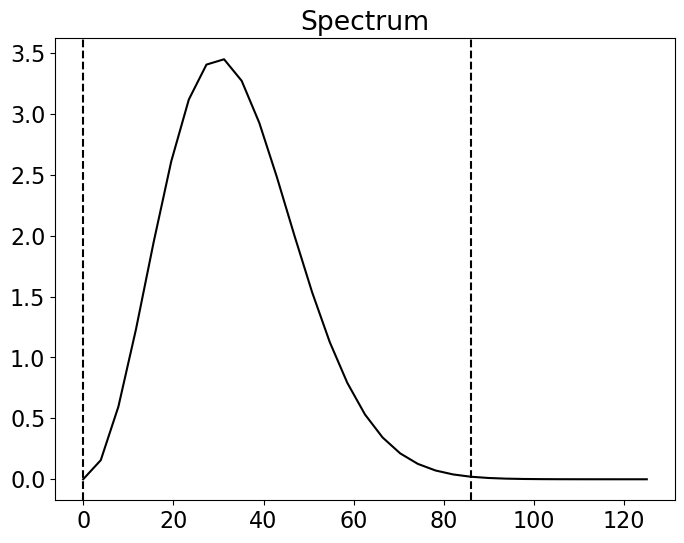

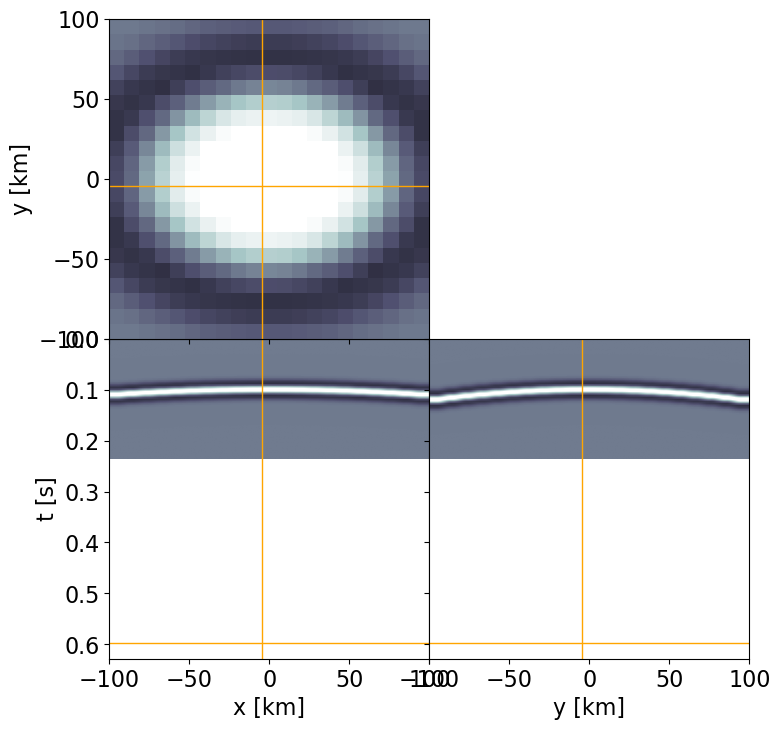

In [33]:
# Create axis (small centered)
par = {'ot': 0,    'dt': 0.004, 'nt': 60,
       'ox': -100, 'dx': 10, 'nx': 21,
       'oy': -100, 'dy': 10, 'ny': 21,
       'f0': 30}
theta = [30, ]
phi = [10, ]
t0 = [0.1, ]
amp = [1., ]

# Create axis (small shifted)
#par = {'ot': 0,    'dt': 0.004, 'nt': 101,
#       'ox': 0, 'dx': 10, 'nx': 51,
#       'oy': -250, 'dy': 10, 'ny': 51,
#       'f0': 40}
#theta = [30, ]
#phi = [10, ]
#t0 = 0.1
#amp = 1.

# Create axis (large centered)
#par = {'ot': 0,    'dt': 0.004, 'nt': 501,
#       'ox': -1000, 'dx': 10, 'nx': 201,
#       'oy': -250, 'dy': 10, 'ny': 51,
#       'f0': 40}
#theta = [30, ]
#phi = [10, ]
#t0 = [0.8, ]
#amp = [1., ]

# Create axis
t, t2, x, y = pylops.utils.seismicevents.makeaxis(par)
dt, dx, dy = par['dt'], par['dx'], par['dy']

# Create wavelet
wav = pylops.utils.wavelets.ricker(t[:41], f0=par['f0'])[0]

# Generate model
if kind == "linear":
    v = 1500.
    pxx = np.sin(np.deg2rad(theta)) * np.cos(np.deg2rad(phi)) / v
    pyy = np.sin(np.deg2rad(theta)) * np.sin(np.deg2rad(phi)) / v
    _, d = \
    pylops.utils.seismicevents.linear3d(x, y, t, v, t0, theta, phi, amp, wav)

    npxy, pxymax = 2 * par['nx'], 5e-4
    px = np.linspace(-pxymax, pxymax, npxy)
    px_fou = px
    py = np.linspace(-pxymax, pxymax, npxy)
    py_fou = px
else:
    pxx = 1e-6 * par['dx']
    pyy = 2e-6 * par['dy']
    _, d = \
        pylops.utils.seismicevents.parabolic3d(x, y, t, t0, 0, 0, pxx / par['dx'], pyy / par['dy'], amp, wav)
    npxy, pxymax = par['nx'], 5e-6
    px = np.linspace(-pxymax, pxymax, npxy) * par['dx']
    py = np.linspace(-pxymax, pxymax, npxy) * par['dy']
    px_fou = np.linspace(-pxymax, pxymax, npxy)
    py_fou = np.linspace(-pxymax, pxymax, npxy)

nfft = int(2 ** np.ceil(np.log2(par['nt'])))
faxis = np.fft.rfftfreq(nfft, par["dt"])

plt.figure()
plt.plot(faxis, np.abs(np.fft.rfft(d[par['ny']//2, par['nx']//2], n=nfft)), 'k')
if flims is not None:
    plt.axvline(faxis[flims[0]], color='k', linestyle='--')
    plt.axvline(faxis[flims[1]], color='k', linestyle='--')
plt.title('Spectrum')

explode_volume(d.transpose(2, 1, 0), t=25,
               tlim=(t[0], t[-1]), 
               ylim=(y[0], y[-1]), 
               xlim=(x[0], x[-1]));

Standard Radon

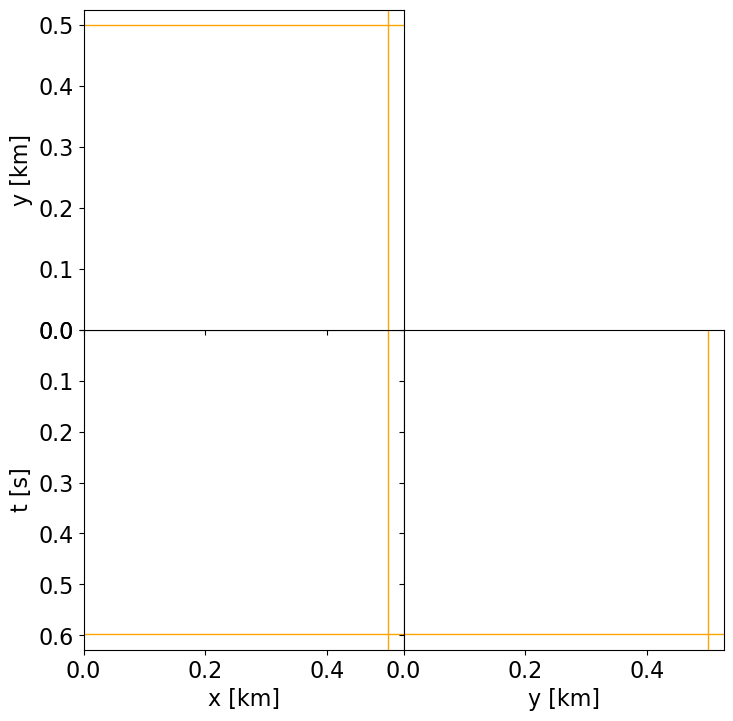

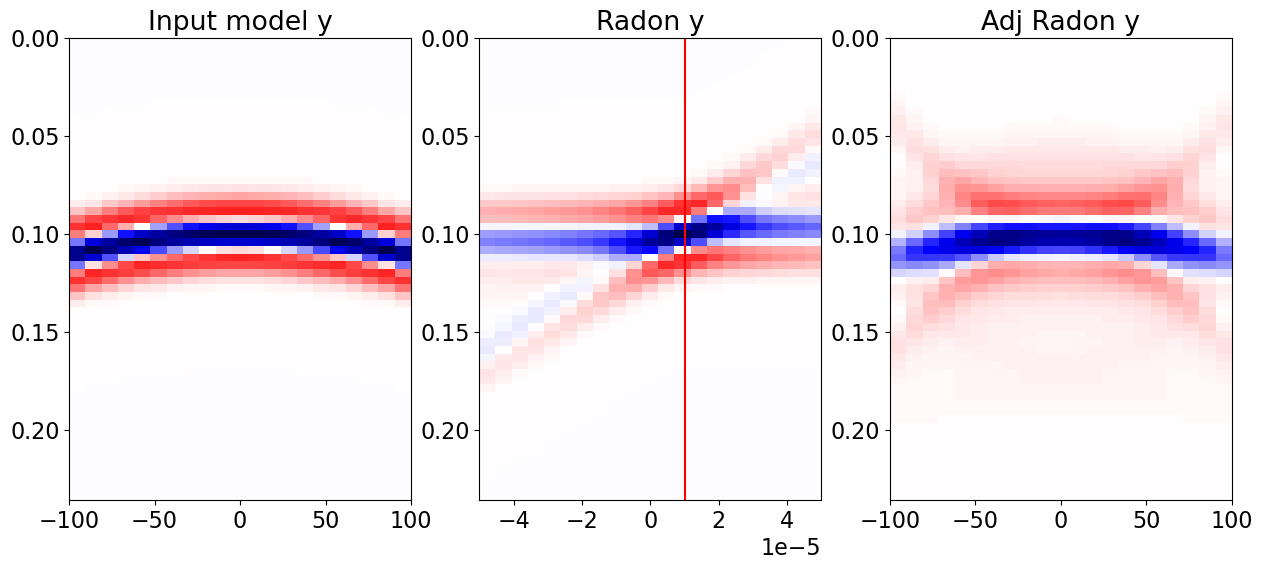

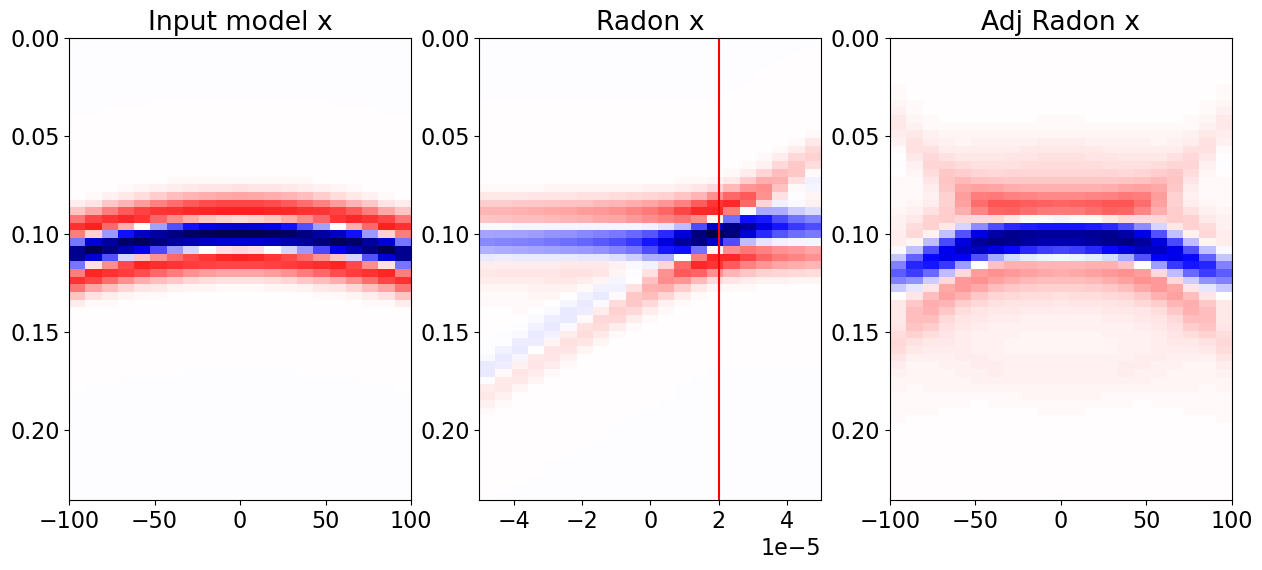

In [34]:
R3Opnormal = Radon3D(t, y, x, py, px, centeredh=False, 
                     kind=kind, dtype='float64', 
                     engine='numba')
dL_normal = R3Opnormal.H * d.reshape(-1, par['nt'])
dadj_normal = R3Opnormal * dL_normal

explode_volume(dL_normal.reshape(npxy, npxy, par['nt']).transpose(2, 1, 0), 
               t=25, x=np.argmin(np.abs(pxx-px)), y=np.argmin(np.abs(pyy-py)),
               tlim=(t[0], t[-1]), 
               ylim=(py[0], py[-1]), 
               xlim=(px[0], px[-1]))

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d[par['ny']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model y')
axs[0].axis('tight')
axs[1].imshow(dL_normal.reshape(npxy, npxy, par['nt'])[np.argmin(np.abs(pyy-py))].T, 
              cmap='seismic_r', vmin=-dL_normal.max(), vmax=dL_normal.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].axvline(pxx, color='r')
axs[1].set_title('Radon y')
axs[1].axis('tight')
axs[2].imshow(dadj_normal.reshape(par['ny'], par['nx'], par['nt'])[par['ny']//2].T, 
              cmap='seismic_r', vmin=-dadj_normal.max(), vmax=dadj_normal.max(),
              extent=(x[0], x[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon y')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d[par['ny']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(y[0], y[-1], t[-1], t[0]))
axs[0].set_title('Input model x')
axs[0].axis('tight')
axs[1].imshow(dL_normal.reshape(npxy, npxy, par['nt'])[:, np.argmin(np.abs(pxx-px))].T, 
              cmap='seismic_r', vmin=-dL_normal.max(), vmax=dL_normal.max(),
              extent=(py[0], py[-1], t[-1], t[0]))
axs[1].axvline(pyy, color='r')
axs[1].set_title('Radon x')
axs[1].axis('tight')
axs[2].imshow(dadj_normal.reshape(par['ny'], par['nx'], par['nt'])[:, par['nx']//2].T, 
              cmap='seismic_r', vmin=-dadj_normal.max(), vmax=dadj_normal.max(),
              extent=(y[0], y[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon x')
axs[2].axis('tight');

Radon in frequency domain (numpy)

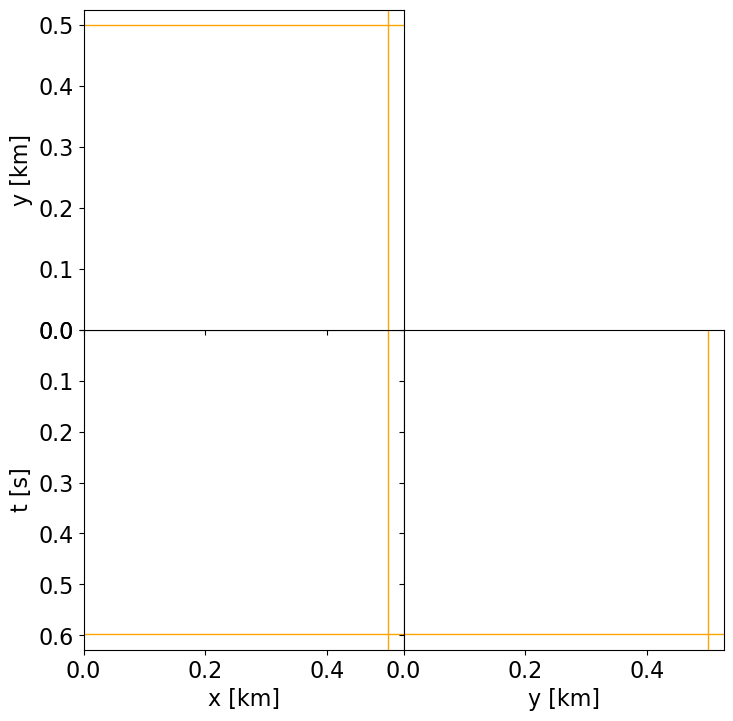

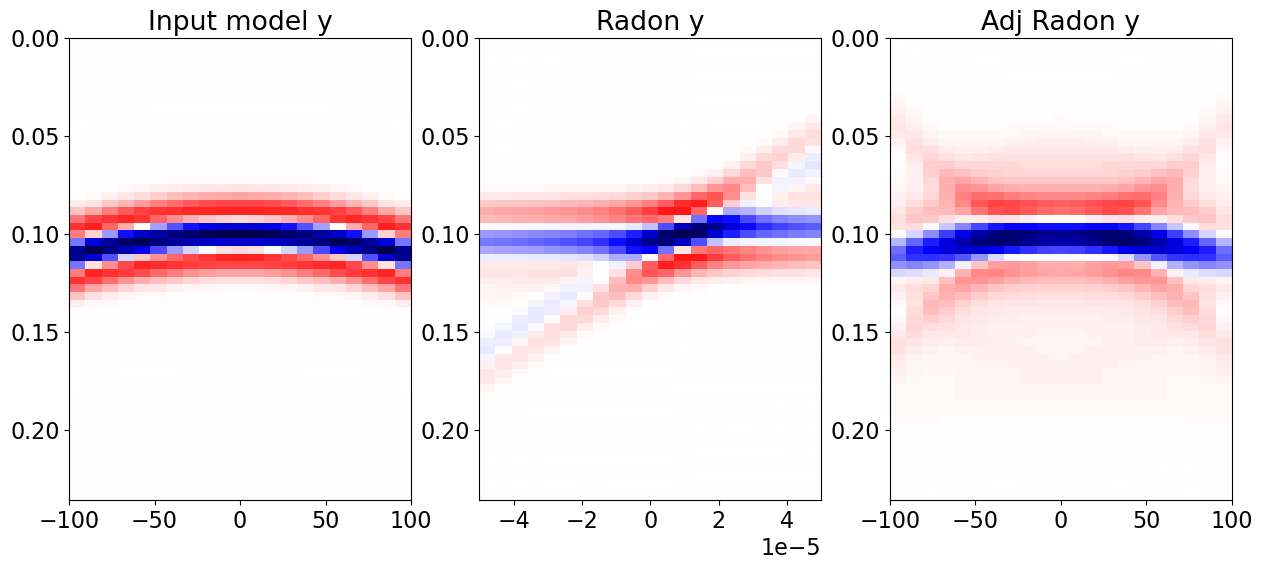

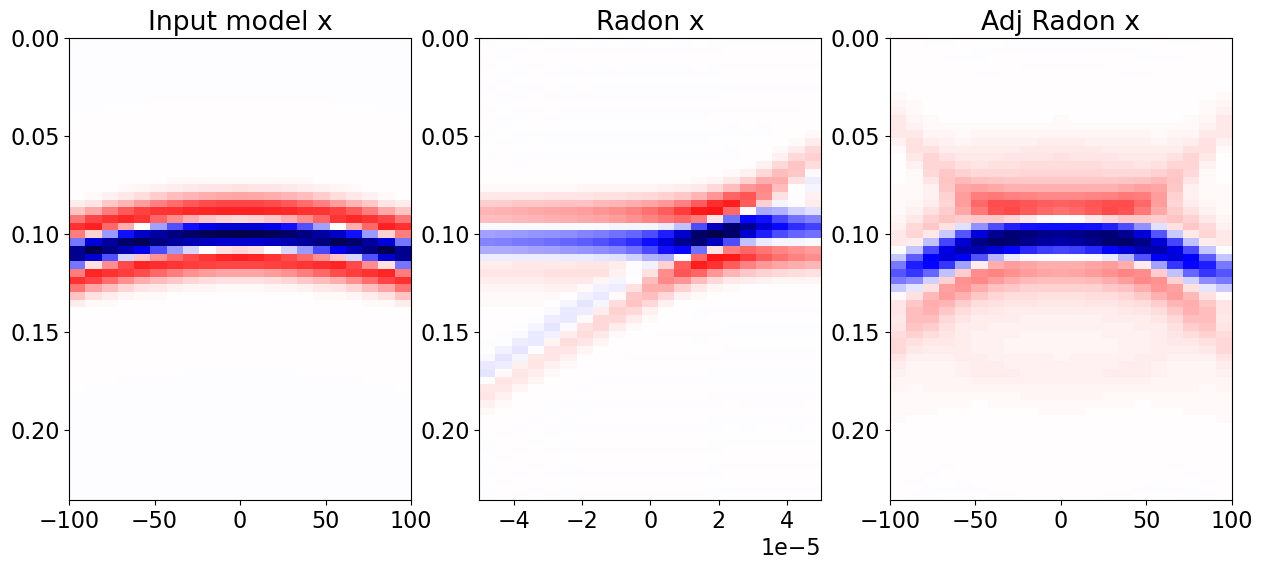

In [35]:
R3Opfourier = FourierRadon3D(t, y, x, py_fou, px_fou, nfft, flims=flims, kind=(kind, kind), engine='numpy', dtype='float64')
dL_four = R3Opfourier.H * d
dadj_four = R3Opfourier * dL_four

explode_volume(dL_four.reshape(npxy, npxy, par['nt']).transpose(2, 1, 0), 
               t=25, x=np.argmin(np.abs(pxx-px)), y=np.argmin(np.abs(pyy-py)),
               tlim=(t[0], t[-1]), 
               ylim=(py[0], py[-1]), 
               xlim=(px[0], px[-1]))

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d[par['ny']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model y')
axs[0].axis('tight')
axs[1].imshow(dL_four.reshape(npxy, npxy, par['nt'])[np.argmin(np.abs(pyy-py))].T, 
              cmap='seismic_r', vmin=-dL_normal.max(), vmax=dL_normal.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon y')
axs[1].axis('tight')
axs[2].imshow(dadj_four.reshape(par['ny'], par['nx'], par['nt'])[par['ny']//2].T, 
              cmap='seismic_r', vmin=-dadj_normal.max(), vmax=dadj_normal.max(),
              extent=(x[0], x[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon y')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d[par['ny']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(y[0], y[-1], t[-1], t[0]))
axs[0].set_title('Input model x')
axs[0].axis('tight')
axs[1].imshow(dL_four.reshape(npxy, npxy, par['nt'])[:, np.argmin(np.abs(pxx-px))].T, 
              cmap='seismic_r', vmin=-dL_normal.max(), vmax=dL_normal.max(),
              extent=(py[0], py[-1], t[-1], t[0]))
axs[1].set_title('Radon x')
axs[1].axis('tight')
axs[2].imshow(dadj_four.reshape(par['ny'], par['nx'], par['nt'])[:, par['nx']//2].T, 
              cmap='seismic_r', vmin=-dadj_normal.max(), vmax=dadj_normal.max(),
              extent=(y[0], y[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon x')
axs[2].axis('tight');

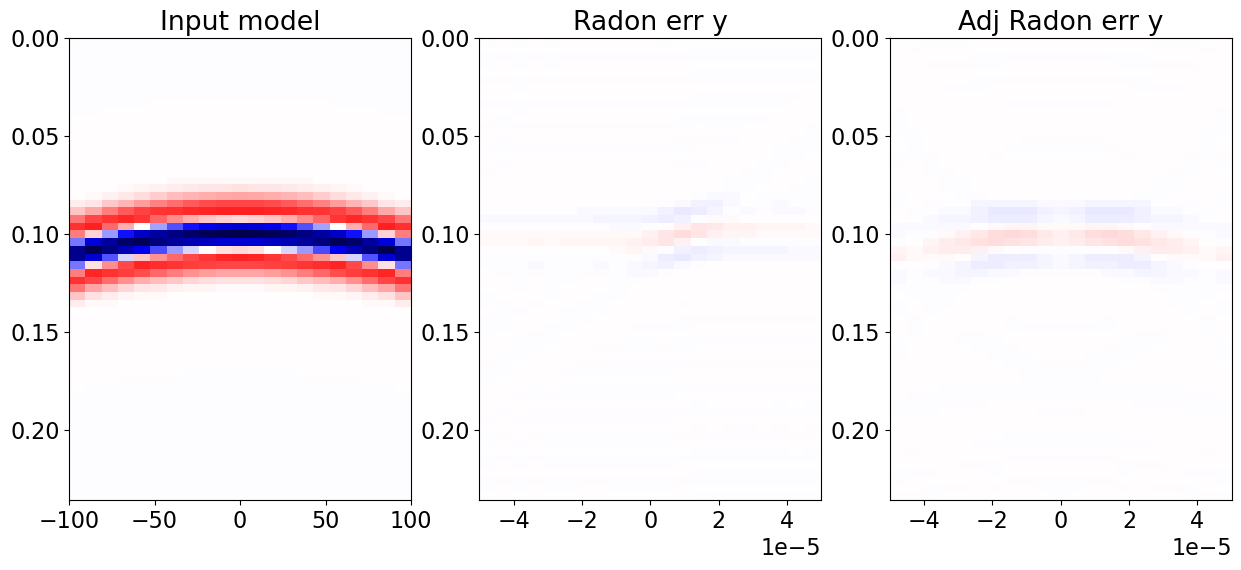

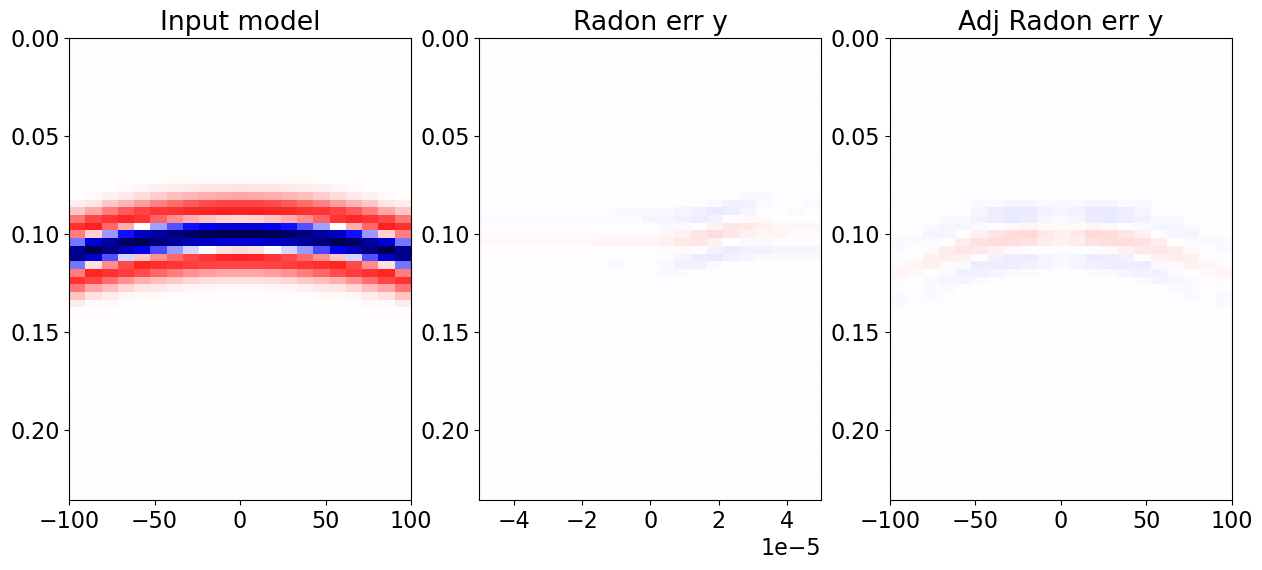

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d[par['ny']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow((dL_normal.reshape(npxy, npxy, par['nt'])-dL_four).reshape(npxy, npxy, par['nt'])[np.argmin(np.abs(pyy-py))].T, 
              cmap='seismic_r', vmin=-dL_normal.max(), vmax=dL_normal.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon err y')
axs[1].axis('tight')
axs[2].imshow((dadj_normal.reshape(par['ny'], par['nx'], par['nt'])-dadj_four).reshape(par['ny'], par['nx'], par['nt'])[par['ny']//2].T, 
              cmap='seismic_r', vmin=-dadj_normal.max(), vmax=dadj_normal.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon err y')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d[par['ny']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(y[0], y[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow((dL_normal.reshape(npxy, npxy, par['nt'])-dL_four).reshape(npxy, npxy, par['nt'])[:, np.argmin(np.abs(pxx-px))].T, 
              cmap='seismic_r', vmin=-dL_normal.max(), vmax=dL_normal.max(),
              extent=(py[0], py[-1], t[-1], t[0]))
axs[1].set_title('Radon err y')
axs[1].axis('tight')
axs[2].imshow((dadj_normal.reshape(par['ny'], par['nx'], par['nt'])-dadj_four).reshape(par['ny'], par['nx'], par['nt'])[:, par['nx']//2].T, 
              cmap='seismic_r', vmin=-dadj_normal.max(), vmax=dadj_normal.max(),
              extent=(y[0], y[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon err y')
axs[2].axis('tight');

Radon in frequency domain (numba)

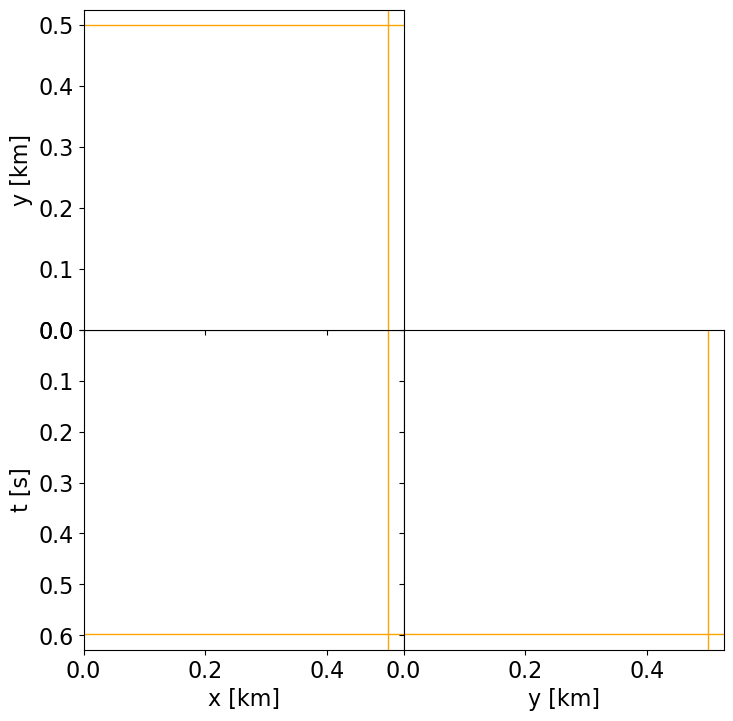

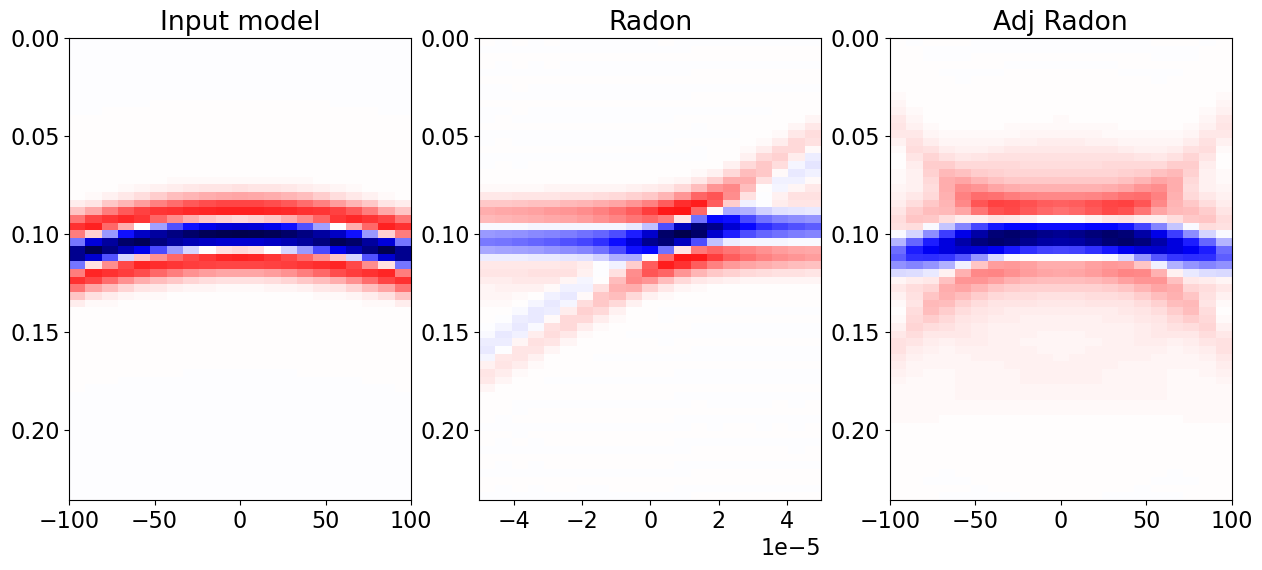

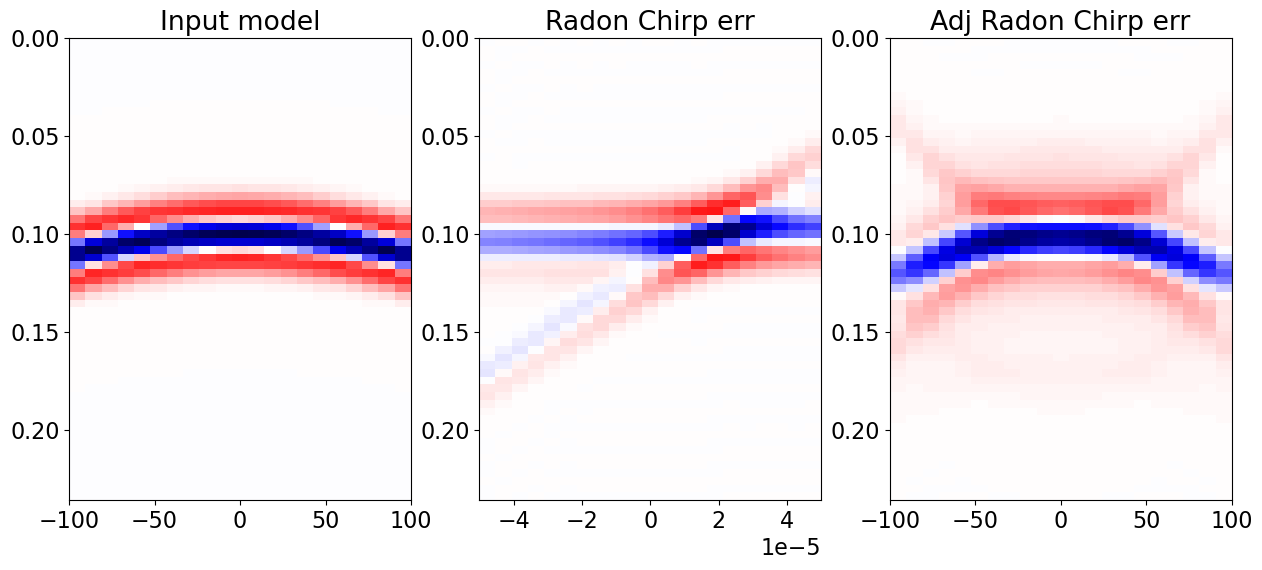

In [37]:
R3Opfouriernb = FourierRadon3D(t, y, x, py_fou, px_fou, nfft, flims=flims, 
                               kind=(kind, kind), engine='numba', dtype='float64')
dL_four = R3Opfouriernb.H * d
dadj_four = R3Opfouriernb * dL_four

explode_volume(dL_four.reshape(npxy, npxy, par['nt']).transpose(2, 1, 0), 
               t=25, x=np.argmin(np.abs(pxx-px)), y=np.argmin(np.abs(pyy-py)),
               tlim=(t[0], t[-1]), 
               ylim=(py[0], py[-1]), 
               xlim=(px[0], px[-1]))

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d[par['ny']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dL_four.reshape(npxy, npxy, par['nt'])[np.argmin(np.abs(pyy-py))].T, 
              cmap='seismic_r', vmin=-dL_normal.max(), vmax=dL_normal.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon')
axs[1].axis('tight')
axs[2].imshow(dadj_four.reshape(par['ny'], par['nx'], par['nt'])[par['ny']//2].T, 
              cmap='seismic_r', vmin=-dadj_normal.max(), vmax=dadj_normal.max(),
              extent=(x[0], x[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon')
axs[2].axis('tight')


fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d[par['ny']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(y[0], y[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dL_four.reshape(npxy, npxy, par['nt'])[:, np.argmin(np.abs(pxx-px))].T, 
              cmap='seismic_r', vmin=-dL_normal.max(), vmax=dL_normal.max(),
              extent=(py[0], py[-1], t[-1], t[0]))
axs[1].set_title('Radon Chirp err')
axs[1].axis('tight')
axs[2].imshow(dadj_four.reshape(par['ny'], par['nx'], par['nt'])[:, par['nx']//2].T, 
              cmap='seismic_r', vmin=-dadj_normal.max(), vmax=dadj_normal.max(),
              extent=(y[0], y[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon Chirp err')
axs[2].axis('tight');

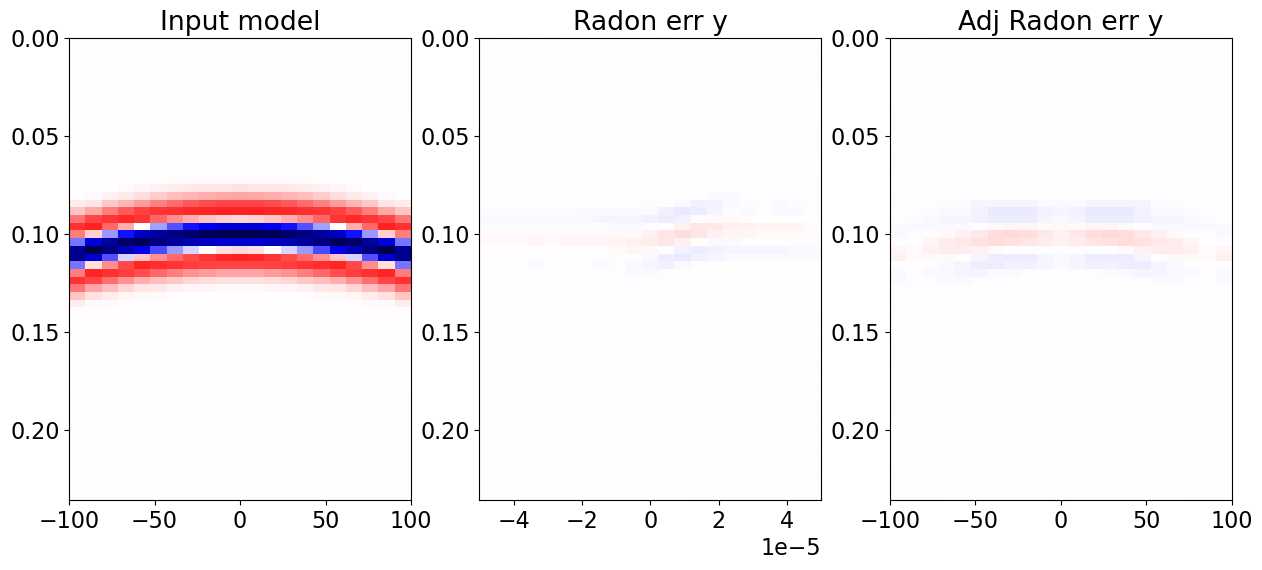

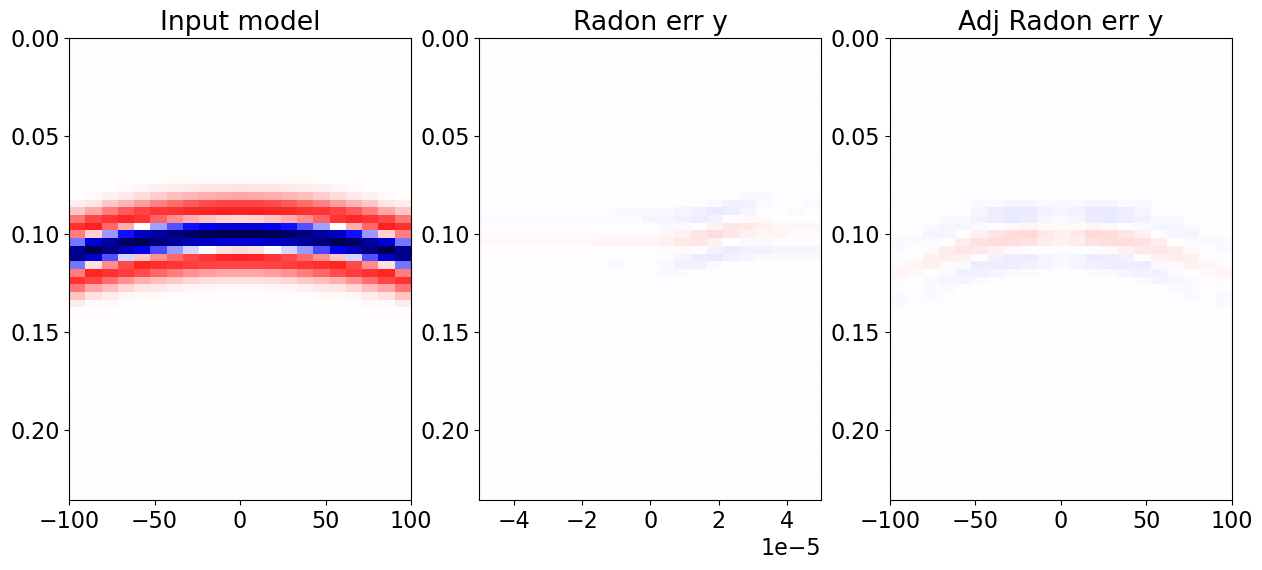

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d[par['ny']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow((dL_normal.reshape(npxy, npxy, par['nt'])-dL_four).reshape(npxy, npxy, par['nt'])[np.argmin(np.abs(pyy-py))].T, 
              cmap='seismic_r', vmin=-dL_normal.max(), vmax=dL_normal.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon err y')
axs[1].axis('tight')
axs[2].imshow((dadj_normal.reshape(par['ny'], par['nx'], par['nt'])-dadj_four).reshape(par['ny'], par['nx'], par['nt'])[par['ny']//2].T, 
              cmap='seismic_r', vmin=-dadj_normal.max(), vmax=dadj_normal.max(),
              extent=(x[0], x[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon err y')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d[par['ny']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(y[0], y[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow((dL_normal.reshape(npxy, npxy, par['nt'])-dL_four).reshape(npxy, npxy, par['nt'])[:, np.argmin(np.abs(pxx-px))].T, 
              cmap='seismic_r', vmin=-dL_normal.max(), vmax=dL_normal.max(),
              extent=(py[0], py[-1], t[-1], t[0]))
axs[1].set_title('Radon err y')
axs[1].axis('tight')
axs[2].imshow((dadj_normal.reshape(par['ny'], par['nx'], par['nt'])-dadj_four).reshape(par['ny'], par['nx'], par['nt'])[:, par['nx']//2].T, 
              cmap='seismic_r', vmin=-dadj_normal.max(), vmax=dadj_normal.max(),
              extent=(y[0], y[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon err y')
axs[2].axis('tight');

In [39]:
dottest(R3Opfourier, R3Opfourier.shape[0], R3Opfourier.shape[1], atol=1e-4, verb=True);
dottest(R3Opfouriernb, R3Opfourier.shape[0], R3Opfourier.shape[1], atol=1e-4, verb=True);

Dot test passed, v^H(Opu)=-1109.0287353621752 - u^H(Op^Hv)=-1109.0287353621793
Dot test passed, v^H(Opu)=-1187.549535568578 - u^H(Op^Hv)=-1187.5495355685764


In [40]:
%timeit -n1 -r 2 R3Opnormal * dL_normal.ravel()
%timeit -n1 -r 2 R3Opnormal.H * d.ravel()

42.1 ms ± 13.2 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
7.66 ms ± 247 µs per loop (mean ± std. dev. of 2 runs, 1 loop each)


In [41]:
%timeit -n4 -r 2 R3Opfourier * dL_normal.ravel()
%timeit -n4 -r 2 R3Opfourier.H * d.ravel()

338 ms ± 450 µs per loop (mean ± std. dev. of 2 runs, 4 loops each)
338 ms ± 1.27 ms per loop (mean ± std. dev. of 2 runs, 4 loops each)


In [42]:
%timeit -n4 -r 2 R3Opfouriernb * dL_normal.ravel()
%timeit -n4 -r 2 R3Opfouriernb.H * d.ravel()

8.16 ms ± 2.07 ms per loop (mean ± std. dev. of 2 runs, 4 loops each)
6.37 ms ± 117 µs per loop (mean ± std. dev. of 2 runs, 4 loops each)
